# Import packages

In [143]:
!pip install -U datasets


In [144]:
from pathlib import Path

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import math
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.data import random_split

from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# Define constants

In [145]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
BATCH_SIZE= 8
PIN_MEMORY= True if DEVICE.type == "cuda" else False

In [147]:
num_epochs= 20
lr= 1e-4
d_model= 512
d_ff= 2048
src_lang= "en"
trg_lang= "hi"
weight_decay= 1e-5
TRAIN_CONSOLE_CHECKPOINT= 300
VALID_CONSOLE_CHECKPOINT= 55

# Components Architecture

### 1) Input embeddings:-

In [186]:
import torch.nn as nn
import math

# Define a custom embedding layer for input tokens
class InputEmbeddings(nn.Module):

    def __init__(self, d_model, vocab_size):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        # Create an embedding layer that maps token indices to vectors of size d_model
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,   # Total number of tokens in vocabulary
            embedding_dim=d_model        # Size of each embedding vector
        )

    def forward(self, x):
        # Scale the embedding by sqrt(d_model) as done in Transformer architecture
        return self.embedding(x) * math.sqrt(self.d_model)


### 2) Positional encodings

In [187]:
import torch
import torch.nn as nn

# Positional encoding module adds information about the position of each token
class PositinalEncodings(nn.Module):

    def __init__(self, d_model, seq_len, dropout_rate):
        super().__init__()

        self.d_model = d_model
        self.seq_len = seq_len

        self.dropout = nn.Dropout(dropout_rate)

        # Initialize positional encoding tensor of shape (seq_len, d_model)
        pe = torch.zeros((seq_len, d_model)).to(DEVICE)  # Shape: (seq_len, d_model)

        # Create position indices (0 to seq_len-1), shape: (seq_len, 1)
        positions = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)

        # Compute the denominator term for sinusoidal functions (only for even indices)
        even_indexes = torch.arange(0, d_model, 2)
        div_term = 10000 ** (-even_indexes / d_model)

        # Apply sine to even indices in the embedding dimension
        pe[:, 0::2] = torch.sin(positions * div_term)

        # Apply cosine to odd indices in the embedding dimension
        pe[:, 1::2] = torch.cos(positions * div_term)

        # Add a batch dimension: (1, seq_len, d_model)
        pe = pe.unsqueeze(0)

        # Register 'pe' as a buffer so it’s not updated by gradients but saved with the model
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input tensor `x`
        # x: (batch_size, seq_len, d_model)
        pos = x + self.pe[:, :x.shape[1], :].requires_grad_(False)

        return self.dropout(pos)


### 3) Feed forward NN

In [188]:
import torch.nn as nn

# Position-wise Feed-Forward Neural Network used in Transformer blocks
class FeedForwardNN(nn.Module):

    def __init__(self, d_model, d_ff, dropout_rate):
        super().__init__()

        self.block = nn.Sequential(
            nn.Linear(
                in_features=d_model,   # Input dimension
                out_features=d_ff      # Hidden dimension
            ),

            nn.ReLU(),

            nn.Dropout(dropout_rate),

            nn.Linear(
                in_features=d_ff,      # Hidden dimension
                out_features=d_model   # Output dimension (same as input)
            )
        )

    def forward(self, x):
        return self.block(x)


### 4) Multi-head attention

In [189]:
class MultiHeadAttention(nn.Module):

  def __init__(self, d_model, num_heads, dropout_rate):

    super().__init__()

    self.d_model= d_model
    self.num_heads= num_heads

    # Ensure d_model is divisible by the number of heads
    assert (d_model % num_heads == 0), f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"


    # Calculate the dimension of each attention head
    self.head_dims= d_model // num_heads

    self.q_dense= nn.Linear(
        in_features= d_model,
        out_features= d_model
    ) # Wq

    self.k_dense= nn.Linear(
        in_features= d_model,
        out_features= d_model
    ) # Wk

    self.v_dense= nn.Linear(
        in_features= d_model,
        out_features= d_model
    ) # Wv

    self.o_dense= nn.Linear(
        in_features= d_model,
        out_features= d_model
    ) # Wo

    self.dropout= nn.Dropout(dropout_rate)


  @staticmethod
  def attention(query, key, values, mask, dropout):

    # queries, keys, values -> (B, num_heads, seq_len, head_dims)
    attention_scores= query @ key.transpose(-2, -1) # (B, num_heads, seq_len, seq_len)
    attention_scores/= math.sqrt(query.shape[-1])

    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)

    attention_scores= nn.Softmax(dim= -1)(attention_scores)

    if dropout is not None:
      attention_scores= dropout(attention_scores)

    output= attention_scores @ values # (B, num_heads, seq_len, head_dims)

    return output, attention_scores



  def forward(self, q, k, v, mask):

    # x -> (seq_len, d_model)
    queries= self.q_dense(q) # (seq_len, d_model)
    keys= self.k_dense(k) # (seq_len, d_model)
    values= self.v_dense(v) # (seq_len, d_model)

    # reshape := (seq_len, d_model) -> (seq_len, num_heads, head_dims)
    queries= queries.view(queries.shape[0], queries.shape[1], self.num_heads, self.head_dims)
    keys= keys.view(keys.shape[0], keys.shape[1], self.num_heads, self.head_dims)
    values= values.view(values.shape[0], values.shape[1], self.num_heads, self.head_dims)

    # reshape := (seq_len, num_heads, head_dims) -> (num_heads, seq_len, head_dims)
    queries= queries.transpose(1, 2)
    keys= keys.transpose(1, 2)
    values= values.transpose(1, 2)


    # get attention outputs
    output, attention_scores= MultiHeadAttention.attention(queries, keys, values, mask, self.dropout)

    # output -> (B, num_heads, seq_len, head_dims)
    output= output.transpose(1, 2) # (B, seq_len, num_heads, head_dims)

    output= output.contiguous().view(output.shape[0], -1, self.num_heads * self.head_dims) # (B, seq_len, d_model)

    return self.o_dense(output) # (B, seq_len, d_model)





### 5) Encoder

In [190]:
class EncoderBlock(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout_rate):

    super().__init__()

    # Multi-Head Self-Attention layer
    self.multi_head_attention= MultiHeadAttention(d_model, num_heads, dropout_rate)

    # Feed Forward Neural Network layer
    self.feed_forward_nn= FeedForwardNN(d_model, d_ff, dropout_rate)

    # Layer normalization (used twice: after attention and FFN)
    self.norm= nn.LayerNorm(
        normalized_shape= d_model
    )

    self.dropout= nn.Dropout(dropout_rate)

  def forward(self, x, mask):

    # Step 1: Multi-Head Self-Attention + Add & Norm
    attention_output= self.multi_head_attention(x, x, x, mask)
    attention_add_norm_output= self.norm(x + self.dropout(attention_output))


    # Step 2: Feed Forward Network + Add & Norm
    nn_output= self.feed_forward_nn(attention_add_norm_output)
    nn_add_norm_out= self.norm(attention_add_norm_output + self.dropout(nn_output))

    return nn_add_norm_out



In [191]:
class Encoder(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout_rate, num_encoder_blocks):

    super().__init__()


    # Stack multiple encoder blocks using ModuleList
    self.encoder_blocks= nn.ModuleList([])

    for _ in range(num_encoder_blocks):
      self.encoder_blocks.append(
          EncoderBlock(d_model, d_ff, num_heads, dropout_rate)
      )


  def forward(self, x, mask):

    # Pass input through each encoder block sequentially
    for block in self.encoder_blocks:
      x= block(x, mask)

    return x


### 6) Decoder

In [192]:
class DecoderBlock(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout_rate):

    super().__init__()

    # Masked self-attention for the decoder
    self.self_attention= MultiHeadAttention(d_model, num_heads, dropout_rate)

     # Cross-attention over the encoder output
    self.cross_attention= MultiHeadAttention(d_model, num_heads, dropout_rate)

    # Position-wise feed forward neural network
    self.feed_forward_nn= FeedForwardNN(d_model, d_ff, dropout_rate)

    # Layer normalization
    self.norm= nn.LayerNorm(
        normalized_shape= d_model
    )

    self.dropout= nn.Dropout(dropout_rate)

  def forward(self, x, enc_out, enc_mask, dec_mask):

    # Step 1: Masked self-attention on decoder input
    self_attention_output= self.self_attention(x, x, x, dec_mask)
    self_attention_add_norm_output= self.norm(x + self.dropout(self_attention_output))

    # Step 2: Cross-attention over encoder output
    cross_attention_output= self.cross_attention(self_attention_add_norm_output, enc_out, enc_out, enc_mask)
    cross_attention_add_norm_output= self.norm(cross_attention_output + self.dropout(self_attention_add_norm_output))

    # Step 3: Feed Forward Network + Add & Norm
    nn_output= self.feed_forward_nn(cross_attention_add_norm_output)
    nn_add_norm_out= self.norm(cross_attention_add_norm_output + self.dropout(nn_output))

    return nn_add_norm_out



In [193]:
class Decoder(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout_rate, num_decoder_blocks):

    super().__init__()

    self.decoder_blocks= nn.ModuleList([])

    for _ in range(num_decoder_blocks):
      self.decoder_blocks.append(
          DecoderBlock(d_model, d_ff, num_heads, dropout_rate)
      )

  def forward(self, x, enc_out, enc_mask, dec_mask):

    # Pass input through each decoder block sequentially
    for block in self.decoder_blocks:
      x= block(x, enc_out, enc_mask, dec_mask)

    return x


In [194]:
class EmbeddingToVocabProjection(nn.Module):

  def __init__(self, d_model, vocab_size):

    super().__init__()

    self.dense= nn.Linear(
        in_features= d_model,
        out_features= vocab_size
    )

  def forward(self, x):
    # x -> (B, S, d_model)

    out= self.dense(x) # (B, S, vocab_size)
    return torch.log_softmax(out, dim= -1)


# Transformer architecture

In [195]:
class Transformer(nn.Module):

  def __init__(self, encoder, decoder, enc_input, enc_pos, dec_input, dec_pos, final_projection):
    super().__init__()

    # Encoder model consisting of multiple EncoderBlocks
    self.encoder_model = encoder

    # Decoder model consisting of multiple DecoderBlocks
    self.decoder_model = decoder

    # Encoder: embedding layer for input tokens
    self.enc_input_model = enc_input

    # Encoder: positional encoding layer for input tokens
    self.enc_pos_model = enc_pos

    # Decoder: embedding layer for target tokens
    self.dec_input_model = dec_input

    # Decoder: positional encoding layer for target tokens
    self.dec_pos_model = dec_pos

    # Final linear projection layer to convert decoder output to vocabulary logits
    self.final_projection_model = final_projection

  def encode(self, enc_input, enc_mask):
    # Generate token embeddings for encoder input
    enc_embeddings = self.enc_input_model(enc_input)

    # Add positional embeddings
    enc_positional_embeddings = self.enc_pos_model(enc_embeddings)

    # Pass through encoder
    enc_output = self.encoder_model(enc_positional_embeddings, enc_mask)

    return enc_output

  def decode(self, dec_input, enc_output, enc_mask, dec_mask):
    # Generate token embeddings for decoder input
    dec_embeddings = self.dec_input_model(dec_input)

    # Add positional embeddings
    dec_positional_embeddings = self.dec_pos_model(dec_embeddings)

    # Pass through decoder
    dec_output = self.decoder_model(dec_positional_embeddings, enc_output, enc_mask, dec_mask)

    return dec_output

  def final_projection(self, dec_output):
    # Project decoder output to vocabulary logits
    return self.final_projection_model(dec_output)


In [196]:
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)

    if m.bias is not None:
      nn.init.zeros_(m.bias)

In [197]:
def build_transformer(src_vocab_size, trg_vocab_size, src_seq_len, trg_seq_len, d_model= 512, d_ff= 2048, num_heads= 8, num_enc_dec_blocks= 6, dropout_rate= 0.1):

  # src -> ENC
  # trg -> DEC

  # create the input embeddings
  enc_embedding= InputEmbeddings(d_model, src_vocab_size)
  dec_embedding= InputEmbeddings(d_model, trg_vocab_size)

  # create the positional embeddings
  enc_pos_embedding= PositinalEncodings(d_model, src_seq_len, dropout_rate)
  dec_pos_embedding= PositinalEncodings(d_model, trg_seq_len, dropout_rate)

  # create the encoder and decoder
  encoder_model= Encoder(d_model, d_ff, num_heads, dropout_rate, num_enc_dec_blocks)
  decoder_model= Decoder(d_model, d_ff, num_heads, dropout_rate, num_enc_dec_blocks)

  # create the final projection layer
  final_projection_model= EmbeddingToVocabProjection(d_model, trg_vocab_size)

  # create the transformer
  transformer_model= Transformer(encoder_model, decoder_model, enc_embedding, enc_pos_embedding, dec_embedding, dec_pos_embedding, final_projection_model)

  # weight init.
  transformer_model.apply(lambda m: init_weights(m))

  return transformer_model


# Tokenizations

In [160]:
ds = load_dataset("cfilt/iitb-english-hindi", split= "train")

ds= ds.select(range(15000))

In [161]:
ds[0]

{'translation': {'en': 'Give your application an accessibility workout',
  'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}

In [162]:
len(ds)

15000

In [163]:
# sentence extractor
def get_all_sentences(ds, lang):
  for item in ds:
    yield item["translation"][lang]

In [164]:
# Function to build or load a tokenizer for a specific language dataset
def build_tokenizer(ds, lang, save_path):
  path = Path(save_path)

  # If tokenizer file already exists, load it
  if path.exists():
    tokenizer = Tokenizer.from_file(str(path))

  else:
    # Create a new tokenizer with WordLevel model and [UNK] as the unknown token
    tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))

    # Use whitespace to split text during tokenization
    tokenizer.pre_tokenizer = Whitespace()

    # Define trainer with special tokens and minimum frequency threshold
    trainer = WordLevelTrainer(
      special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"],  # Special tokens
      min_frequency=1  # Keep all tokens that appear at least once
    )

    # Train the tokenizer on all sentences in the dataset for the given language
    tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)

    # Save the trained tokenizer to file
    tokenizer.save(str(path))

  return tokenizer  # Return the loaded or newly trained tokenizer


In [165]:
# get the tokenizers
tokenizer_src = build_tokenizer(ds, 'en', '/content/tokenizer_en.json')
tokenizer_trg = build_tokenizer(ds, 'hi', '/content/tokenizer_hi.json')


In [166]:
tokenizer_src.token_to_id("[UNK]")

0

In [167]:
text_en = "This is a sentence."
text_hi = "यह एक वाक्य है।"

print("English tokens:", tokenizer_src.encode(text_en).ids)
print("Hindi tokens:", tokenizer_trg.encode(text_hi).ids)


English tokens: [296, 52, 10, 0, 6]
Hindi tokens: [65, 19, 1981, 17, 194]


In [168]:
max_src_len = 0
max_trg_len = 0

for item in ds:
  src_text = item['translation']['en']
  trg_text = item['translation']['hi']

  src_len = len(tokenizer_src.encode(src_text).ids)
  trg_len = len(tokenizer_trg.encode(trg_text).ids)

  max_src_len = max(max_src_len, src_len)
  max_trg_len = max(max_trg_len, trg_len)

# Decide final seq_len (with SOS and EOS)
final_seq_len = max(max_src_len, max_trg_len) + 2  # Add SOS and EOS
print("Recommended seq_len:", final_seq_len)

Recommended seq_len: 100


# Dataset

In [169]:
def causal_mask(size):
  mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int64)
  return (mask == 0)


In [170]:
causal_mask(5).shape, causal_mask(5)

(torch.Size([1, 5, 5]),
 tensor([[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]]))

In [171]:
# Custom PyTorch dataset class for sequence-to-sequence translation tasks
class CustomDataset(Dataset):

  def __init__(self, ds, tokenizer_src, tokenizer_trg, seq_len, src_lang="en", trg_lang="hi"):
    self.ds = ds  # Hugging Face translation dataset
    self.tokenizer_src = tokenizer_src  # Source language tokenizer
    self.tokenizer_trg = tokenizer_trg  # Target language tokenizer
    self.seq_len = seq_len  # Maximum sequence length

    self.src_lang = src_lang  # Source language code
    self.trg_lang = trg_lang  # Target language code

    # Special tokens
    self.sos_token = torch.tensor([tokenizer_src.token_to_id("[SOS]")])
    self.eos_token = torch.tensor([tokenizer_src.token_to_id("[EOS]")])
    self.pad_token = torch.tensor([tokenizer_src.token_to_id("[PAD]")])

  def __len__(self):
    return len(self.ds)  # Total number of samples

  def __getitem__(self, id):
    # Get translation pair from dataset
    src_trg_pair = ds[id]["translation"]

    # Extract source and target texts
    src_text = src_trg_pair[self.src_lang]
    trg_text = src_trg_pair[self.trg_lang]

    # Tokenize the source and target sentences
    src_token_ids = self.tokenizer_src.encode(src_text).ids
    trg_token_ids = self.tokenizer_trg.encode(trg_text).ids

    # Compute padding lengths (subtracting SOS/EOS tokens)
    src_num_padding = self.seq_len - len(src_token_ids) - 2  # SOS + EOS
    trg_num_padding = self.seq_len - len(trg_token_ids) - 1  # Only EOS

    if src_num_padding < 0 or trg_num_padding < 0:
      print(f"Too long sentence :(")  # Optionally handle truncation here

    # Create encoder input: [SOS] + tokens + [EOS] + [PAD]...
    enc_inputs = torch.cat([
        self.sos_token,
        torch.tensor(src_token_ids, dtype=torch.int64),
        self.eos_token,
        torch.tensor([self.pad_token] * src_num_padding, dtype=torch.int64)
    ], dim=0)

    # Create decoder input: [SOS] + tokens + [PAD]...
    dec_inputs = torch.cat([
        self.sos_token,
        torch.tensor(trg_token_ids, dtype=torch.int64),
        torch.tensor([self.pad_token] * trg_num_padding, dtype=torch.int64)
    ], dim=0)

    # Create decoder target labels: tokens + [EOS] + [PAD]...
    labels = torch.cat([
        torch.tensor(trg_token_ids, dtype=torch.int64),
        self.eos_token,
        torch.tensor([self.pad_token] * trg_num_padding, dtype=torch.int64)
    ], dim=0)

    # Return the sample as a dictionary
    return {
      "enc_inputs": enc_inputs,  # Input to encoder
      "dec_inputs": dec_inputs,  # Input to decoder
      "labels": labels,          # Target output
      "src_text": src_text,      # Raw source text
      "trg_text": trg_text,      # Raw target text
      "encoder_mask": (enc_inputs != self.pad_token).unsqueeze(0).unsqueeze(0).int(),  # 3D encoder mask
      "decoder_mask": (dec_inputs != self.pad_token).unsqueeze(0).int() & causal_mask(dec_inputs.size(0))  # Combined decoder mask
    }


In [172]:
# split the raw ds

ds_len= len(ds)
train_ds_len= int(0.80 * ds_len)
valid_ds_len= int(0.15 * ds_len)
test_ds_len= ds_len - train_ds_len - valid_ds_len

train_ds, valid_ds, test_ds= random_split(ds, [train_ds_len, valid_ds_len, test_ds_len])

In [173]:
# get the datasets -> train and valid

train_dataset= CustomDataset(train_ds, tokenizer_src, tokenizer_trg, final_seq_len)
valid_dataset= CustomDataset(valid_ds, tokenizer_src, tokenizer_trg, final_seq_len)
test_dataset= CustomDataset(test_ds, tokenizer_src, tokenizer_trg, final_seq_len)

In [174]:
# get the data loaders -> train and valid

BATCH_SIZE= 8

train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True, pin_memory= True)
valid_loader= DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle= True, pin_memory= True)
test_loader= DataLoader(test_dataset, batch_size= 1, shuffle= True, pin_memory= True)

In [175]:
dic= next(iter(train_loader))

dic['enc_inputs'].shape, dic['dec_inputs'].shape, dic["labels"].shape, len(dic["src_text"]), len(dic["trg_text"]), dic["encoder_mask"].shape, dic["decoder_mask"].shape

(torch.Size([8, 100]),
 torch.Size([8, 100]),
 torch.Size([8, 100]),
 8,
 8,
 torch.Size([8, 1, 1, 100]),
 torch.Size([8, 1, 100, 100]))

# Training inits.

In [198]:
# src vocab size -> tokenizer_src.get_vocab_size()
# dest vocab size -> tokenizer_trg.get_vocab_size()

In [199]:
# define the transformer model

model= build_transformer(tokenizer_src.get_vocab_size(), tokenizer_trg.get_vocab_size(), final_seq_len, final_seq_len, num_heads= 4, num_enc_dec_blocks= 4)
model= model.to(DEVICE)

In [200]:
model

Transformer(
  (encoder_model): Encoder(
    (encoder_blocks): ModuleList(
      (0-3): 4 x EncoderBlock(
        (multi_head_attention): MultiHeadAttention(
          (q_dense): Linear(in_features=512, out_features=512, bias=True)
          (k_dense): Linear(in_features=512, out_features=512, bias=True)
          (v_dense): Linear(in_features=512, out_features=512, bias=True)
          (o_dense): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_nn): FeedForwardNN(
          (block): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder_model): Decoder(
    (decoder

In [201]:
# opt and loss

optimizer= optim.Adam(model.parameters(), lr= lr, weight_decay= weight_decay)
loss_func= nn.CrossEntropyLoss(ignore_index= tokenizer_src.token_to_id('[PAD]'), label_smoothing= 0.1)

In [202]:
train_losses= []
valid_losses= []

len(train_loader)

1500

In [203]:
tokenizer_trg.get_vocab_size()

2615

# Training

In [204]:
len(train_loader), len(valid_loader), len(test_loader)

(1500, 282, 750)

In [205]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(12000, 2250, 750)

In [207]:
def train_validation_model(model):

  best_epoch= 0
  min_valid_loss= float("inf")
  transformer_best_weights_path= "/content/weights.pth"


  for epoch in range(num_epochs):

    print(f"\nRunning epoch [{epoch + 1}/{num_epochs}]:-\n\n")

    # training loop
    model.train()

    total_train_loss= 0

    train_loop= tqdm(train_loader, desc= "Training", total= len(train_loader))

    batch_id= 0

    for batch in train_loop:

      # get the inputs
      enc_inputs= batch["enc_inputs"].to(DEVICE) # (b, seq_len)
      dec_inputs= batch["dec_inputs"].to(DEVICE) # (b, seq_len)
      labels= batch["labels"].to(DEVICE) # (b, seq_len)
      src_text= batch["src_text"] # (b)
      trg_text= batch["trg_text"] # (b)
      encoder_mask= batch["encoder_mask"].to(DEVICE) # (b, 1, 1, seq_len)
      decoder_mask= batch["decoder_mask"].to(DEVICE) # (b, 1, seq_len, seq_len)

      # calc the model preds
      enc_outputs= model.encode(enc_inputs, encoder_mask) # (b, seq_len, d_model)
      dec_outputs= model.decode(dec_inputs, enc_outputs, encoder_mask, decoder_mask) # (b, seq_len, d_model)
      final_projections= model.final_projection(dec_outputs) # (b, seq_len, vocab_size)

      # calc loss:= (b * seq_len, vocab_size) -> (b * seq_len)
      loss= loss_func(final_projections.view(-1, final_projections.shape[-1]), labels.view(-1))

      # update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      # display
      train_loop.set_postfix({
          "loss": f"{loss.item():.4f}"
      })

      if (batch_id + 1) % TRAIN_CONSOLE_CHECKPOINT == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] ~ Batch [{batch_id + 1}] -> Train Loss: {loss.item():.4f}")

      total_train_loss+= loss.item()

      batch_id+= 1

    avg_train_loss= total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    # validation loop
    model.eval()

    total_valid_loss= 0

    valid_loop= tqdm(valid_loader, desc= "Validation", total= len(valid_loader))

    batch_id= 0

    for batch in valid_loop:

      # get the inputs
      enc_inputs= batch["enc_inputs"].to(DEVICE) # (b, seq_len)
      dec_inputs= batch["dec_inputs"].to(DEVICE) # (b, seq_len)
      labels= batch["labels"].to(DEVICE) # (b, seq_len)
      src_text= batch["src_text"] # (b)
      trg_text= batch["trg_text"] # (b)
      encoder_mask= batch["encoder_mask"].to(DEVICE) # (b, 1, 1, seq_len)
      decoder_mask= batch["decoder_mask"].to(DEVICE) # (b, 1, seq_len, seq_len)

      # calc the model preds
      with torch.no_grad():
        enc_outputs= model.encode(enc_inputs, encoder_mask) # (b, seq_len, d_model)
        dec_outputs= model.decode(dec_inputs, enc_outputs, encoder_mask, decoder_mask) # (b, seq_len, d_model)
        final_projections= model.final_projection(dec_outputs) # (b, seq_len, vocab_size)

        # calc loss:= (b * seq_len, vocab_size) -> (b * seq_len)
        loss= loss_func(final_projections.view(-1, final_projections.shape[-1]), labels.view(-1))

      # display
      valid_loop.set_postfix({
          "loss": f"{loss.item():.4f}"
      })

      if (batch_id + 1) % VALID_CONSOLE_CHECKPOINT == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] ~ Batch [{batch_id + 1}] -> Valid Loss: {loss.item():.4f}")

      total_valid_loss+= loss.item()

      batch_id+= 1

    avg_valid_loss= total_valid_loss / len(valid_loader)

    # save best weights
    if avg_valid_loss < min_valid_loss:
      min_valid_loss= avg_valid_loss
      best_epoch= epoch
      torch.save(model.state_dict(), transformer_best_weights_path)  # Save model weights


    valid_losses.append(avg_valid_loss)
    print(f"\n\nEpoch [{epoch + 1}/{num_epochs}] -> Avg Train Loss: {avg_train_loss:.4f} ~ Avg Valid Loss: {avg_valid_loss:.4f}\n\n")

    # load best weights if its the last epoch
    if (epoch + 1) == num_epochs:

      model= build_transformer(tokenizer_src.get_vocab_size(), tokenizer_trg.get_vocab_size(), final_seq_len, final_seq_len, num_heads= 4, num_enc_dec_blocks= 3)
      model.load_state_dict(torch.load(transformer_best_weights_path))  # Load saved weights
      model= model.to(DEVICE)

      print(f"\n\nTraining done, loading the best weights...")





In [208]:
train_validation_model(model)


Running epoch [1/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [1/20] ~ Batch [300] -> Train Loss: 5.1664
Epoch [1/20] ~ Batch [600] -> Train Loss: 4.1069
Epoch [1/20] ~ Batch [900] -> Train Loss: 4.8370
Epoch [1/20] ~ Batch [1200] -> Train Loss: 3.6289
Epoch [1/20] ~ Batch [1500] -> Train Loss: 6.7962


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [1/20] ~ Batch [55] -> Valid Loss: 4.7785
Epoch [1/20] ~ Batch [110] -> Valid Loss: 4.6358
Epoch [1/20] ~ Batch [165] -> Valid Loss: 4.5806
Epoch [1/20] ~ Batch [220] -> Valid Loss: 5.7407
Epoch [1/20] ~ Batch [275] -> Valid Loss: 4.7059


Epoch [1/20] -> Avg Train Loss: 4.9820 ~ Avg Valid Loss: 4.1446



Running epoch [2/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [2/20] ~ Batch [300] -> Train Loss: 3.6280
Epoch [2/20] ~ Batch [600] -> Train Loss: 4.0131
Epoch [2/20] ~ Batch [900] -> Train Loss: 3.8426
Epoch [2/20] ~ Batch [1200] -> Train Loss: 3.3027
Epoch [2/20] ~ Batch [1500] -> Train Loss: 2.0983


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [2/20] ~ Batch [55] -> Valid Loss: 3.3875
Epoch [2/20] ~ Batch [110] -> Valid Loss: 4.0623
Epoch [2/20] ~ Batch [165] -> Valid Loss: 2.3465
Epoch [2/20] ~ Batch [220] -> Valid Loss: 4.1795
Epoch [2/20] ~ Batch [275] -> Valid Loss: 2.0466


Epoch [2/20] -> Avg Train Loss: 3.8154 ~ Avg Valid Loss: 3.0169



Running epoch [3/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [3/20] ~ Batch [300] -> Train Loss: 3.8999
Epoch [3/20] ~ Batch [600] -> Train Loss: 3.3677
Epoch [3/20] ~ Batch [900] -> Train Loss: 3.2814
Epoch [3/20] ~ Batch [1200] -> Train Loss: 3.5798
Epoch [3/20] ~ Batch [1500] -> Train Loss: 2.6363


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [3/20] ~ Batch [55] -> Valid Loss: 2.1261
Epoch [3/20] ~ Batch [110] -> Valid Loss: 2.8558
Epoch [3/20] ~ Batch [165] -> Valid Loss: 1.9760
Epoch [3/20] ~ Batch [220] -> Valid Loss: 2.3878
Epoch [3/20] ~ Batch [275] -> Valid Loss: 2.9954


Epoch [3/20] -> Avg Train Loss: 3.1329 ~ Avg Valid Loss: 2.2476



Running epoch [4/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [4/20] ~ Batch [300] -> Train Loss: 2.6885
Epoch [4/20] ~ Batch [600] -> Train Loss: 3.0114
Epoch [4/20] ~ Batch [900] -> Train Loss: 3.0074
Epoch [4/20] ~ Batch [1200] -> Train Loss: 3.4419
Epoch [4/20] ~ Batch [1500] -> Train Loss: 1.9293


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [4/20] ~ Batch [55] -> Valid Loss: 2.3914
Epoch [4/20] ~ Batch [110] -> Valid Loss: 1.7914
Epoch [4/20] ~ Batch [165] -> Valid Loss: 1.4699
Epoch [4/20] ~ Batch [220] -> Valid Loss: 1.7075
Epoch [4/20] ~ Batch [275] -> Valid Loss: 2.8310


Epoch [4/20] -> Avg Train Loss: 2.6467 ~ Avg Valid Loss: 1.8625



Running epoch [5/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [5/20] ~ Batch [300] -> Train Loss: 3.5228
Epoch [5/20] ~ Batch [600] -> Train Loss: 2.5743
Epoch [5/20] ~ Batch [900] -> Train Loss: 2.1986
Epoch [5/20] ~ Batch [1200] -> Train Loss: 2.6425
Epoch [5/20] ~ Batch [1500] -> Train Loss: 1.8489


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [5/20] ~ Batch [55] -> Valid Loss: 1.7632
Epoch [5/20] ~ Batch [110] -> Valid Loss: 1.6103
Epoch [5/20] ~ Batch [165] -> Valid Loss: 1.5117
Epoch [5/20] ~ Batch [220] -> Valid Loss: 2.2608
Epoch [5/20] ~ Batch [275] -> Valid Loss: 1.4694


Epoch [5/20] -> Avg Train Loss: 2.3216 ~ Avg Valid Loss: 1.6513



Running epoch [6/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [6/20] ~ Batch [300] -> Train Loss: 1.5843
Epoch [6/20] ~ Batch [600] -> Train Loss: 1.5367
Epoch [6/20] ~ Batch [900] -> Train Loss: 1.8960
Epoch [6/20] ~ Batch [1200] -> Train Loss: 2.1850
Epoch [6/20] ~ Batch [1500] -> Train Loss: 2.9115


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [6/20] ~ Batch [55] -> Valid Loss: 1.2805
Epoch [6/20] ~ Batch [110] -> Valid Loss: 1.3098
Epoch [6/20] ~ Batch [165] -> Valid Loss: 1.3780
Epoch [6/20] ~ Batch [220] -> Valid Loss: 1.2875
Epoch [6/20] ~ Batch [275] -> Valid Loss: 1.5673


Epoch [6/20] -> Avg Train Loss: 2.1163 ~ Avg Valid Loss: 1.5517



Running epoch [7/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [7/20] ~ Batch [300] -> Train Loss: 1.7345
Epoch [7/20] ~ Batch [600] -> Train Loss: 2.3293
Epoch [7/20] ~ Batch [900] -> Train Loss: 1.7337
Epoch [7/20] ~ Batch [1200] -> Train Loss: 2.1864
Epoch [7/20] ~ Batch [1500] -> Train Loss: 2.1599


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [7/20] ~ Batch [55] -> Valid Loss: 1.5142
Epoch [7/20] ~ Batch [110] -> Valid Loss: 1.3006
Epoch [7/20] ~ Batch [165] -> Valid Loss: 1.4042
Epoch [7/20] ~ Batch [220] -> Valid Loss: 1.4451
Epoch [7/20] ~ Batch [275] -> Valid Loss: 1.3675


Epoch [7/20] -> Avg Train Loss: 1.9725 ~ Avg Valid Loss: 1.4718



Running epoch [8/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [8/20] ~ Batch [300] -> Train Loss: 2.3360
Epoch [8/20] ~ Batch [600] -> Train Loss: 1.9074
Epoch [8/20] ~ Batch [900] -> Train Loss: 2.1767
Epoch [8/20] ~ Batch [1200] -> Train Loss: 1.8972
Epoch [8/20] ~ Batch [1500] -> Train Loss: 1.6001


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [8/20] ~ Batch [55] -> Valid Loss: 1.2512
Epoch [8/20] ~ Batch [110] -> Valid Loss: 1.9495
Epoch [8/20] ~ Batch [165] -> Valid Loss: 1.4357
Epoch [8/20] ~ Batch [220] -> Valid Loss: 1.4058
Epoch [8/20] ~ Batch [275] -> Valid Loss: 1.3232


Epoch [8/20] -> Avg Train Loss: 1.8632 ~ Avg Valid Loss: 1.3989



Running epoch [9/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [9/20] ~ Batch [300] -> Train Loss: 1.8236
Epoch [9/20] ~ Batch [600] -> Train Loss: 1.7106
Epoch [9/20] ~ Batch [900] -> Train Loss: 1.3975
Epoch [9/20] ~ Batch [1200] -> Train Loss: 1.7428
Epoch [9/20] ~ Batch [1500] -> Train Loss: 1.6222


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [9/20] ~ Batch [55] -> Valid Loss: 2.2050
Epoch [9/20] ~ Batch [110] -> Valid Loss: 1.3226
Epoch [9/20] ~ Batch [165] -> Valid Loss: 1.2719
Epoch [9/20] ~ Batch [220] -> Valid Loss: 1.3963
Epoch [9/20] ~ Batch [275] -> Valid Loss: 1.2520


Epoch [9/20] -> Avg Train Loss: 1.7854 ~ Avg Valid Loss: 1.3643



Running epoch [10/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [10/20] ~ Batch [300] -> Train Loss: 2.7149
Epoch [10/20] ~ Batch [600] -> Train Loss: 1.3586
Epoch [10/20] ~ Batch [900] -> Train Loss: 1.4214
Epoch [10/20] ~ Batch [1200] -> Train Loss: 1.3766
Epoch [10/20] ~ Batch [1500] -> Train Loss: 2.0849


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [10/20] ~ Batch [55] -> Valid Loss: 1.6576
Epoch [10/20] ~ Batch [110] -> Valid Loss: 1.6279
Epoch [10/20] ~ Batch [165] -> Valid Loss: 1.3860
Epoch [10/20] ~ Batch [220] -> Valid Loss: 1.2800
Epoch [10/20] ~ Batch [275] -> Valid Loss: 1.4865


Epoch [10/20] -> Avg Train Loss: 1.7195 ~ Avg Valid Loss: 1.3466



Running epoch [11/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [11/20] ~ Batch [300] -> Train Loss: 1.4072
Epoch [11/20] ~ Batch [600] -> Train Loss: 1.8272
Epoch [11/20] ~ Batch [900] -> Train Loss: 2.0005
Epoch [11/20] ~ Batch [1200] -> Train Loss: 1.9126
Epoch [11/20] ~ Batch [1500] -> Train Loss: 2.4451


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [11/20] ~ Batch [55] -> Valid Loss: 1.2568
Epoch [11/20] ~ Batch [110] -> Valid Loss: 1.2971
Epoch [11/20] ~ Batch [165] -> Valid Loss: 1.3860
Epoch [11/20] ~ Batch [220] -> Valid Loss: 1.2342
Epoch [11/20] ~ Batch [275] -> Valid Loss: 1.3611


Epoch [11/20] -> Avg Train Loss: 1.6604 ~ Avg Valid Loss: 1.3319



Running epoch [12/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [12/20] ~ Batch [300] -> Train Loss: 1.4954
Epoch [12/20] ~ Batch [600] -> Train Loss: 1.4395
Epoch [12/20] ~ Batch [900] -> Train Loss: 1.3359
Epoch [12/20] ~ Batch [1200] -> Train Loss: 2.1005
Epoch [12/20] ~ Batch [1500] -> Train Loss: 1.5895


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [12/20] ~ Batch [55] -> Valid Loss: 1.3039
Epoch [12/20] ~ Batch [110] -> Valid Loss: 1.3487
Epoch [12/20] ~ Batch [165] -> Valid Loss: 1.3281
Epoch [12/20] ~ Batch [220] -> Valid Loss: 1.2838
Epoch [12/20] ~ Batch [275] -> Valid Loss: 1.2823


Epoch [12/20] -> Avg Train Loss: 1.6169 ~ Avg Valid Loss: 1.3265



Running epoch [13/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [13/20] ~ Batch [300] -> Train Loss: 1.3570
Epoch [13/20] ~ Batch [600] -> Train Loss: 1.3551
Epoch [13/20] ~ Batch [900] -> Train Loss: 1.4637
Epoch [13/20] ~ Batch [1200] -> Train Loss: 1.9395
Epoch [13/20] ~ Batch [1500] -> Train Loss: 1.2731


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [13/20] ~ Batch [55] -> Valid Loss: 1.2605
Epoch [13/20] ~ Batch [110] -> Valid Loss: 1.2568
Epoch [13/20] ~ Batch [165] -> Valid Loss: 1.2591
Epoch [13/20] ~ Batch [220] -> Valid Loss: 1.2845
Epoch [13/20] ~ Batch [275] -> Valid Loss: 1.3022


Epoch [13/20] -> Avg Train Loss: 1.5799 ~ Avg Valid Loss: 1.3169



Running epoch [14/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [14/20] ~ Batch [300] -> Train Loss: 1.3845
Epoch [14/20] ~ Batch [600] -> Train Loss: 1.6064
Epoch [14/20] ~ Batch [900] -> Train Loss: 1.8843
Epoch [14/20] ~ Batch [1200] -> Train Loss: 1.5439
Epoch [14/20] ~ Batch [1500] -> Train Loss: 1.8550


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [14/20] ~ Batch [55] -> Valid Loss: 1.2711
Epoch [14/20] ~ Batch [110] -> Valid Loss: 1.3388
Epoch [14/20] ~ Batch [165] -> Valid Loss: 1.2571
Epoch [14/20] ~ Batch [220] -> Valid Loss: 1.3083
Epoch [14/20] ~ Batch [275] -> Valid Loss: 1.2876


Epoch [14/20] -> Avg Train Loss: 1.5484 ~ Avg Valid Loss: 1.3153



Running epoch [15/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [15/20] ~ Batch [300] -> Train Loss: 1.5539
Epoch [15/20] ~ Batch [600] -> Train Loss: 1.8369
Epoch [15/20] ~ Batch [900] -> Train Loss: 1.3290
Epoch [15/20] ~ Batch [1200] -> Train Loss: 1.4650
Epoch [15/20] ~ Batch [1500] -> Train Loss: 1.6820


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [15/20] ~ Batch [55] -> Valid Loss: 1.2604
Epoch [15/20] ~ Batch [110] -> Valid Loss: 1.3395
Epoch [15/20] ~ Batch [165] -> Valid Loss: 1.3401
Epoch [15/20] ~ Batch [220] -> Valid Loss: 1.2811
Epoch [15/20] ~ Batch [275] -> Valid Loss: 1.2961


Epoch [15/20] -> Avg Train Loss: 1.5271 ~ Avg Valid Loss: 1.2977



Running epoch [16/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [16/20] ~ Batch [300] -> Train Loss: 1.2892
Epoch [16/20] ~ Batch [600] -> Train Loss: 1.4626
Epoch [16/20] ~ Batch [900] -> Train Loss: 1.4895
Epoch [16/20] ~ Batch [1200] -> Train Loss: 1.3249
Epoch [16/20] ~ Batch [1500] -> Train Loss: 1.3789


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [16/20] ~ Batch [55] -> Valid Loss: 1.2598
Epoch [16/20] ~ Batch [110] -> Valid Loss: 1.2768
Epoch [16/20] ~ Batch [165] -> Valid Loss: 1.2481
Epoch [16/20] ~ Batch [220] -> Valid Loss: 1.3688
Epoch [16/20] ~ Batch [275] -> Valid Loss: 1.3043


Epoch [16/20] -> Avg Train Loss: 1.5007 ~ Avg Valid Loss: 1.2916



Running epoch [17/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [17/20] ~ Batch [300] -> Train Loss: 1.4027
Epoch [17/20] ~ Batch [600] -> Train Loss: 1.3706
Epoch [17/20] ~ Batch [900] -> Train Loss: 2.1755
Epoch [17/20] ~ Batch [1200] -> Train Loss: 1.6658
Epoch [17/20] ~ Batch [1500] -> Train Loss: 1.3790


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [17/20] ~ Batch [55] -> Valid Loss: 1.2955
Epoch [17/20] ~ Batch [110] -> Valid Loss: 1.2559
Epoch [17/20] ~ Batch [165] -> Valid Loss: 1.4081
Epoch [17/20] ~ Batch [220] -> Valid Loss: 1.2407
Epoch [17/20] ~ Batch [275] -> Valid Loss: 1.2474


Epoch [17/20] -> Avg Train Loss: 1.4772 ~ Avg Valid Loss: 1.2832



Running epoch [18/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [18/20] ~ Batch [300] -> Train Loss: 1.3127
Epoch [18/20] ~ Batch [600] -> Train Loss: 1.4390
Epoch [18/20] ~ Batch [900] -> Train Loss: 1.6984
Epoch [18/20] ~ Batch [1200] -> Train Loss: 1.2767
Epoch [18/20] ~ Batch [1500] -> Train Loss: 1.5846


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [18/20] ~ Batch [55] -> Valid Loss: 1.2201
Epoch [18/20] ~ Batch [110] -> Valid Loss: 1.2891
Epoch [18/20] ~ Batch [165] -> Valid Loss: 1.2604
Epoch [18/20] ~ Batch [220] -> Valid Loss: 1.2629
Epoch [18/20] ~ Batch [275] -> Valid Loss: 1.2933


Epoch [18/20] -> Avg Train Loss: 1.4721 ~ Avg Valid Loss: 1.2831



Running epoch [19/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [19/20] ~ Batch [300] -> Train Loss: 1.5100
Epoch [19/20] ~ Batch [600] -> Train Loss: 1.8165
Epoch [19/20] ~ Batch [900] -> Train Loss: 1.4095
Epoch [19/20] ~ Batch [1200] -> Train Loss: 1.5631
Epoch [19/20] ~ Batch [1500] -> Train Loss: 1.2820


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [19/20] ~ Batch [55] -> Valid Loss: 1.3255
Epoch [19/20] ~ Batch [110] -> Valid Loss: 1.3460
Epoch [19/20] ~ Batch [165] -> Valid Loss: 1.3625
Epoch [19/20] ~ Batch [220] -> Valid Loss: 1.3693
Epoch [19/20] ~ Batch [275] -> Valid Loss: 1.2759


Epoch [19/20] -> Avg Train Loss: 1.4515 ~ Avg Valid Loss: 1.2830



Running epoch [20/20]:-




Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [20/20] ~ Batch [300] -> Train Loss: 1.5488
Epoch [20/20] ~ Batch [600] -> Train Loss: 1.4506
Epoch [20/20] ~ Batch [900] -> Train Loss: 1.2837
Epoch [20/20] ~ Batch [1200] -> Train Loss: 1.3181
Epoch [20/20] ~ Batch [1500] -> Train Loss: 1.3575


Validation:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [20/20] ~ Batch [55] -> Valid Loss: 1.2480
Epoch [20/20] ~ Batch [110] -> Valid Loss: 1.2403
Epoch [20/20] ~ Batch [165] -> Valid Loss: 1.2499
Epoch [20/20] ~ Batch [220] -> Valid Loss: 1.2488
Epoch [20/20] ~ Batch [275] -> Valid Loss: 1.2692


Epoch [20/20] -> Avg Train Loss: 1.4378 ~ Avg Valid Loss: 1.2688




RuntimeError: Error(s) in loading state_dict for Transformer:
	Unexpected key(s) in state_dict: "encoder_model.encoder_blocks.3.multi_head_attention.q_dense.weight", "encoder_model.encoder_blocks.3.multi_head_attention.q_dense.bias", "encoder_model.encoder_blocks.3.multi_head_attention.k_dense.weight", "encoder_model.encoder_blocks.3.multi_head_attention.k_dense.bias", "encoder_model.encoder_blocks.3.multi_head_attention.v_dense.weight", "encoder_model.encoder_blocks.3.multi_head_attention.v_dense.bias", "encoder_model.encoder_blocks.3.multi_head_attention.o_dense.weight", "encoder_model.encoder_blocks.3.multi_head_attention.o_dense.bias", "encoder_model.encoder_blocks.3.feed_forward_nn.block.0.weight", "encoder_model.encoder_blocks.3.feed_forward_nn.block.0.bias", "encoder_model.encoder_blocks.3.feed_forward_nn.block.3.weight", "encoder_model.encoder_blocks.3.feed_forward_nn.block.3.bias", "encoder_model.encoder_blocks.3.norm.weight", "encoder_model.encoder_blocks.3.norm.bias", "decoder_model.decoder_blocks.3.self_attention.q_dense.weight", "decoder_model.decoder_blocks.3.self_attention.q_dense.bias", "decoder_model.decoder_blocks.3.self_attention.k_dense.weight", "decoder_model.decoder_blocks.3.self_attention.k_dense.bias", "decoder_model.decoder_blocks.3.self_attention.v_dense.weight", "decoder_model.decoder_blocks.3.self_attention.v_dense.bias", "decoder_model.decoder_blocks.3.self_attention.o_dense.weight", "decoder_model.decoder_blocks.3.self_attention.o_dense.bias", "decoder_model.decoder_blocks.3.cross_attention.q_dense.weight", "decoder_model.decoder_blocks.3.cross_attention.q_dense.bias", "decoder_model.decoder_blocks.3.cross_attention.k_dense.weight", "decoder_model.decoder_blocks.3.cross_attention.k_dense.bias", "decoder_model.decoder_blocks.3.cross_attention.v_dense.weight", "decoder_model.decoder_blocks.3.cross_attention.v_dense.bias", "decoder_model.decoder_blocks.3.cross_attention.o_dense.weight", "decoder_model.decoder_blocks.3.cross_attention.o_dense.bias", "decoder_model.decoder_blocks.3.feed_forward_nn.block.0.weight", "decoder_model.decoder_blocks.3.feed_forward_nn.block.0.bias", "decoder_model.decoder_blocks.3.feed_forward_nn.block.3.weight", "decoder_model.decoder_blocks.3.feed_forward_nn.block.3.bias", "decoder_model.decoder_blocks.3.norm.weight", "decoder_model.decoder_blocks.3.norm.bias". 

# Plot train and validation metrics

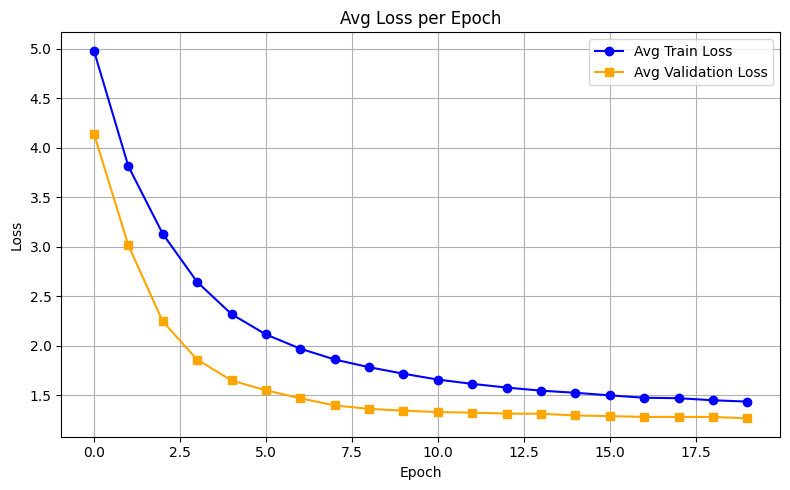

In [209]:
# Plot

plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o', linestyle='-', color='blue', label='Avg Train Loss')
plt.plot(valid_losses, marker='s', label='Avg Validation Loss', color='orange')
plt.title("Avg Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Transformer inference

In [210]:
# Greedy decoding function for inference (generates one token at a time)
def greedy_decode(encoder_inputs, encoder_mask):

  # Get the special token IDs
  sos_id = tokenizer_src.token_to_id('[SOS]')  # Start of sentence
  eos_id = tokenizer_src.token_to_id('[EOS]')  # End of sentence

  # Run the encoder to get encoder outputs
  encoder_outputs = model.encode(encoder_inputs, encoder_mask)

  # Initialize decoder input with only SOS token: shape (1, 1)
  decoder_inputs = torch.empty((1, 1)).fill_(sos_id).type_as(encoder_inputs).to(DEVICE)

  while True:
    # Stop if the sequence becomes too long
    if decoder_inputs.shape[1] >= final_seq_len:
      break

    # Create the causal (triangular) mask for decoder (prevents seeing future tokens)
    decoder_mask = causal_mask(decoder_inputs.shape[1]).type_as(encoder_mask).to(DEVICE)

    # Run the decoder to get output logits
    decoder_outputs = model.decode(decoder_inputs, encoder_outputs, encoder_mask, decoder_mask)

    # Get the final (last time step) logits from decoder
    probs = model.final_projection(decoder_outputs[:, -1])  # Shape: (1, vocab_size)

    # Choose the token with the highest probability (greedy)
    _, highest_prob_index = torch.max(probs, dim=1)  # Shape: (1,)

    # Append predicted token to decoder input for next step
    decoder_inputs = torch.cat([
        decoder_inputs,
        torch.empty((1, 1)).fill_(highest_prob_index.item()).type_as(encoder_inputs).to(DEVICE)
    ], dim=1)

    # Stop if EOS token is generated
    if highest_prob_index == eos_id:
      break

  # Return the generated token sequence (excluding batch dim)
  return decoder_inputs.squeeze(0)


In [211]:
# Inference loop to evaluate the Transformer model on test data
def transformer_inference():

  # Set model to evaluation mode (disables dropout, etc.)
  model.eval()

  # Create a tqdm progress bar for test_loader
  test_loop = tqdm(test_loader, desc="Testing", total=len(test_loader))

  # Initialize storage for logging results
  source_texts = []     # Source sentences (English)
  target_texts = []     # Ground truth target sentences (Hindi)
  predicted_texts = []  # Model-generated translations

  for batch in test_loop:

    # Move tensors to DEVICE (e.g., GPU)
    enc_inputs = batch["enc_inputs"].to(DEVICE)           # Encoder input sequence (1, seq_len)
    dec_inputs = batch["dec_inputs"].to(DEVICE)           # Decoder input sequence (1, seq_len)
    labels = batch["labels"].to(DEVICE)                   # Ground truth target sequence (1, seq_len)
    src_text = batch["src_text"]                          # Source sentence as string (list of one string)
    trg_text = batch["trg_text"]                          # Target sentence as string (list of one string)
    encoder_mask = batch["encoder_mask"].to(DEVICE)       # Encoder attention mask (1, 1, 1, seq_len)
    decoder_mask = batch["decoder_mask"].to(DEVICE)       # Decoder attention mask (1, 1, seq_len, seq_len)

    # Get prediction from the greedy decoder
    model_out = greedy_decode(enc_inputs, encoder_mask)

    # Collect original and predicted texts for comparison
    source_texts.append(src_text[0])  # English sentence
    target_texts.append(trg_text[0])  # Actual Hindi sentence
    predicted_texts.append(tokenizer_trg.decode(model_out.detach().cpu().numpy()))  # Predicted Hindi

  # Print all translations: source, target (ground truth), and predicted
  for i in range(len(source_texts)):
    print(f"\nSRC: {source_texts[i]}")  # Original English input
    print(f"TRG: {target_texts[i]}")    # Ground truth Hindi translation
    print(f"PRD: {predicted_texts[i]}") # Model's Hindi prediction
    print(f"\n{'-' * 50}")


In [212]:
transformer_inference()

Testing:   0%|          | 0/750 [00:00<?, ?it/s]


SRC: Give your application an accessibility workout
TRG: अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
PRD: अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें

--------------------------------------------------

SRC: C _ lear Selection
TRG: चुनाव को हटाएं (C _) 
PRD: चुनाव को हटाएं ( C _ )

--------------------------------------------------

SRC: Dogtail
TRG: श्वानपुच्छ
PRD: श्वानपुच्छ

--------------------------------------------------

SRC: Plugin View (% d)
TRG: प्लग-इन दृश्य (% d) 
PRD: प्लग - इन दृश्य (% d )

--------------------------------------------------

SRC: % (rolename) s parent index% (num1) d does not match row and column index% (num2) d
TRG: % (rolename) s अभिभावक सूची% (num1) d पंक्ति और स्तंभ सूची% (num2) d से मेल नहीं खाते
PRD: % ( rolename ) s अभिभावक सूची % ( num1 ) d पंक्ति और स्तंभ सूची % ( num2 ) d से मेल नहीं खाते

--------------------------------------------------

SRC: Lo _ gin Helper
TRG: प्रवेश सहायक
PRD: प्रवेश सहायक

--------------------------------------